In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [5]:
import sys
from tqdm import tqdm
import time
import copy

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import numpy as np
 
# Set seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
 
def get_data_loaders(data_dir, batch_size):
    transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.20),
        T.RandomRotation(degrees=(-45, 45)),
        T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10)),
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
 
    full_dataset = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/augmented-20x-10x/20x/20x/augmented"), transform=transform)
 
    # Calculate the sizes of the training and validation sets
    dataset_size = len(full_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = dataset_size - train_size
 
    # Manually split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
 
    test_transform = T.Compose([
        T.Resize(438),
        T.CenterCrop(384),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
 
    test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/augmented-20x-10x/20x/20x/test"), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
 
    return train_loader, val_loader, test_loader, len(train_dataset), len(val_dataset), len(test_data)

In [8]:
data_dir = "/kaggle/input/augmented-20x-10x/20x/20x/augmented/"
batch_size = 128
train_loader, val_loader, test_loader, train_size, val_size, test_size = get_data_loaders(data_dir, batch_size)

In [9]:
classes = get_classes("/kaggle/input/augmented-20x-10x/20x/20x/augmented/")

In [10]:
# Get Class Names
class_names = sorted(os.listdir(data_dir))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['Small_ROIs_EF', 'Small_ROIs_IN']
Number of Classes  : 2


In [11]:
# Calculate class distribution
class_dis = [len(os.listdir(data_dir + name)) for name in class_names]
class_dis

[6012, 4917]

In [12]:
# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [13]:
pred_dataset_path = "/kaggle/input/augmented-20x-10x/20x/20x/augmented/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [14]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}

dataset_sizes = {
    "train": train_size,
    "val": val_size
}

In [15]:
print(len(train_loader), len(val_loader), len(test_loader))

60 26 5


In [16]:
print("Train dataset size:", train_size)
print("Validation dataset size:", val_size)
print("Test dataset size:", test_size)

Train dataset size: 7650
Validation dataset size: 3279
Test dataset size: 595


In [17]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
import torch
# check you have the right version of timm
import timm

# now load it with torchhub

model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:13<00:00, 26.0MB/s] 


In [19]:
import torch.nn as nn

# Assuming 'model' is your existing model

# Freeze all parameters in the existing model
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features of the existing fc layer
n_inputs = model.head.in_features

# Modify the fc layer and add more layers for reducing val loss
model.head = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.BatchNorm1d(1024),  # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),   # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),   # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),   # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),    # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(classes))
)

# L2 regularization for all linear layers
l2_lambda = 0.01
for layer in model.head.children():
    if isinstance(layer, nn.Linear):
        layer.weight.data = nn.Parameter(layer.weight.data, requires_grad=True)
        layer.bias.data = nn.Parameter(layer.bias.data, requires_grad=True)
        layer.weight.data = layer.weight.data.add(-l2_lambda * layer.weight.data)

model = model.to(device)

# Print the modified model architecture
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [20]:
import torch.optim as optim
# Add weight decay to the optimizer
weight_decay = 1e-5  # You can adjust this value based on your needs
optimizer = optim.AdamW(model.head.parameters(), lr=0.001, weight_decay=weight_decay)
# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=200, patience=500):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    val_true_labels = []
    val_pred_labels = []
    val_pred_probs = []
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    val_true_labels += labels.tolist()
                    val_pred_labels += preds.tolist()
                    val_pred_probs += torch.softmax(outputs, dim=1).tolist()

            if phase == 'train':
                train_loss_history.append(running_loss / dataset_sizes[phase])
            else:
                val_loss_history.append(running_loss / dataset_sizes[phase])

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, running_loss / dataset_sizes[phase], epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                no_improvement_count = 0
            elif phase == 'val':
                no_improvement_count += 1

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

        print()

        if no_improvement_count >= patience:
            print(f"No improvement in validation accuracy for {no_improvement_count} epochs. Early stopping...")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)


    # Calculate confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)
    f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
    sensitivity = confusion_mat.diagonal() / confusion_mat.sum(axis=1)
    specificity = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    accuracy = np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat)
    true_positives = np.diag(confusion_mat)
    true_negatives = np.sum(confusion_mat) - (np.sum(true_positives) + np.sum(confusion_mat.sum(axis=0)) - np.sum(true_positives))
    false_positives = confusion_mat.sum(axis=0) - true_positives
    false_negatives = confusion_mat.sum(axis=1) - true_positives
    kappa = cohen_kappa_score(val_true_labels, val_pred_labels)

    # Print confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    print("Confusion Matrix:")
    print(confusion_mat)
    print("F1 Score: {:.4f}".format(f1))
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy: {:.4f}".format(accuracy))
    print("True Positives:", true_positives)
    print("True Negatives:", true_negatives)
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    print("Cohen's Kappa:", kappa)


    # Print classification report
    target_names = [str(i) for i in range(len(classes))]
    print(classification_report(val_true_labels, val_pred_labels, target_names=target_names))
    
    
    
    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_acc_history) + 1), y=train_acc_history, label='Train', linestyle='-', color='#DC8686')
    sns.lineplot(x=range(1, len(val_acc_history) + 1), y=val_acc_history, label='Validation', linestyle='-', color='#59CE8F')

    # Create a band around the train line
    plt.fill_between(range(1, len(train_acc_history) + 1), np.array(train_acc_history) - 0.02, np.array(train_acc_history) + 0.02, color='#DC8686', alpha=0.2)

    # Create a band around the validation line
    plt.fill_between(range(1, len(val_acc_history) + 1), np.array(val_acc_history) - 0.02, np.array(val_acc_history) + 0.02, color='#59CE8F', alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label='Train', linestyle='-', color='#DC8686')
    sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label='Validation', linestyle='-', color='#59CE8F')

    # Create a band around the train line
    plt.fill_between(range(1, len(train_loss_history) + 1), np.array(train_loss_history) - 0.02, np.array(train_loss_history) + 0.02, color='#DC8686', alpha=0.2)

    # Create a band around the validation line
    plt.fill_between(range(1, len(val_loss_history) + 1), np.array(val_loss_history) - 0.02, np.array(val_loss_history) + 0.02, color='#59CE8F', alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()




    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(len(classes)))
    # Plot customized confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="GnBu", linewidths=.5, square=True, cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    
    plt.tight_layout()
    plt.show()

Epoch 0/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


train Loss: 0.6118 Acc: 0.6550


100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


val Loss: 0.4638 Acc: 0.7829

Epoch 1/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.4361 Acc: 0.8008


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.3511 Acc: 0.8371

Epoch 2/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.3867 Acc: 0.8294


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.3104 Acc: 0.8615

Epoch 3/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.3379 Acc: 0.8522


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2811 Acc: 0.8795

Epoch 4/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.3183 Acc: 0.8664


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2853 Acc: 0.8737

Epoch 5/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.3055 Acc: 0.8702


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2705 Acc: 0.8786

Epoch 6/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2838 Acc: 0.8803


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2358 Acc: 0.9033

Epoch 7/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2712 Acc: 0.8868


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2209 Acc: 0.9064

Epoch 8/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2677 Acc: 0.8889


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.2193 Acc: 0.9125

Epoch 9/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2592 Acc: 0.8957


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2204 Acc: 0.9067

Epoch 10/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2498 Acc: 0.8959


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2013 Acc: 0.9137

Epoch 11/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2440 Acc: 0.9017


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2019 Acc: 0.9186

Epoch 12/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2454 Acc: 0.9017


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1938 Acc: 0.9210

Epoch 13/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2365 Acc: 0.8979


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1929 Acc: 0.9186

Epoch 14/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2239 Acc: 0.9129


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.2603 Acc: 0.8866

Epoch 15/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2223 Acc: 0.9120


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1757 Acc: 0.9314

Epoch 16/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2141 Acc: 0.9128


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1668 Acc: 0.9311

Epoch 17/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2146 Acc: 0.9131


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1670 Acc: 0.9341

Epoch 18/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2044 Acc: 0.9187


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1682 Acc: 0.9344

Epoch 19/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.2054 Acc: 0.9170


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1788 Acc: 0.9256

Epoch 20/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.2030 Acc: 0.9192


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1705 Acc: 0.9268

Epoch 21/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1973 Acc: 0.9204


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.1564 Acc: 0.9329

Epoch 22/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1941 Acc: 0.9203


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1577 Acc: 0.9384

Epoch 23/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1985 Acc: 0.9197


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1560 Acc: 0.9350

Epoch 24/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1876 Acc: 0.9267


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1545 Acc: 0.9344

Epoch 25/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1857 Acc: 0.9255


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1835 Acc: 0.9244

Epoch 26/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1808 Acc: 0.9278


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1561 Acc: 0.9357

Epoch 27/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1825 Acc: 0.9278


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1477 Acc: 0.9372

Epoch 28/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1800 Acc: 0.9281


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1435 Acc: 0.9393

Epoch 29/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1763 Acc: 0.9307


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1505 Acc: 0.9427

Epoch 30/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1657 Acc: 0.9349


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1419 Acc: 0.9405

Epoch 31/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1748 Acc: 0.9331


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1297 Acc: 0.9436

Epoch 32/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1648 Acc: 0.9386


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1510 Acc: 0.9402

Epoch 33/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1721 Acc: 0.9329


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1499 Acc: 0.9402

Epoch 34/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1736 Acc: 0.9344


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1152 Acc: 0.9546

Epoch 35/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1654 Acc: 0.9340


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1327 Acc: 0.9494

Epoch 36/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1614 Acc: 0.9357


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1194 Acc: 0.9521

Epoch 37/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1554 Acc: 0.9392


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1358 Acc: 0.9451

Epoch 38/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1534 Acc: 0.9391


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1189 Acc: 0.9549

Epoch 39/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1502 Acc: 0.9395


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1190 Acc: 0.9515

Epoch 40/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1587 Acc: 0.9384


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1217 Acc: 0.9536

Epoch 41/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1485 Acc: 0.9442


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1212 Acc: 0.9503

Epoch 42/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1487 Acc: 0.9455


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1270 Acc: 0.9506

Epoch 43/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1441 Acc: 0.9426


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1114 Acc: 0.9536

Epoch 44/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1511 Acc: 0.9429


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1170 Acc: 0.9506

Epoch 45/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1447 Acc: 0.9458


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1169 Acc: 0.9524

Epoch 46/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1443 Acc: 0.9434


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1052 Acc: 0.9610

Epoch 47/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1430 Acc: 0.9427


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1072 Acc: 0.9591

Epoch 48/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1479 Acc: 0.9418


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1081 Acc: 0.9576

Epoch 49/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1356 Acc: 0.9485


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1136 Acc: 0.9558

Epoch 50/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1394 Acc: 0.9473


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1139 Acc: 0.9539

Epoch 51/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1446 Acc: 0.9441


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1052 Acc: 0.9604

Epoch 52/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1325 Acc: 0.9493


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1032 Acc: 0.9594

Epoch 53/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1368 Acc: 0.9477


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1039 Acc: 0.9591

Epoch 54/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1371 Acc: 0.9472


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1081 Acc: 0.9588

Epoch 55/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1380 Acc: 0.9469


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1026 Acc: 0.9579

Epoch 56/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1262 Acc: 0.9486


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0942 Acc: 0.9628

Epoch 57/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.28it/s]


train Loss: 0.1269 Acc: 0.9489


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0961 Acc: 0.9616

Epoch 58/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1254 Acc: 0.9528


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1048 Acc: 0.9579

Epoch 59/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1296 Acc: 0.9536


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0874 Acc: 0.9634

Epoch 60/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1310 Acc: 0.9498


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0937 Acc: 0.9631

Epoch 61/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1277 Acc: 0.9510


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.1150 Acc: 0.9558

Epoch 62/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1325 Acc: 0.9501


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0885 Acc: 0.9655

Epoch 63/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1253 Acc: 0.9532


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0904 Acc: 0.9646

Epoch 64/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1191 Acc: 0.9548


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0927 Acc: 0.9689

Epoch 65/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


train Loss: 0.1164 Acc: 0.9579


100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


val Loss: 0.0857 Acc: 0.9704

Epoch 66/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1252 Acc: 0.9527


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0960 Acc: 0.9634

Epoch 67/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1222 Acc: 0.9544


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0996 Acc: 0.9600

Epoch 68/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1135 Acc: 0.9565


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.0978 Acc: 0.9646

Epoch 69/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1229 Acc: 0.9562


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0941 Acc: 0.9649

Epoch 70/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1177 Acc: 0.9548


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0921 Acc: 0.9674

Epoch 71/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1106 Acc: 0.9562


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0841 Acc: 0.9665

Epoch 72/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1230 Acc: 0.9503


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0808 Acc: 0.9689

Epoch 73/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1156 Acc: 0.9554


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0888 Acc: 0.9655

Epoch 74/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1176 Acc: 0.9565


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0886 Acc: 0.9622

Epoch 75/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1138 Acc: 0.9586


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.1028 Acc: 0.9616

Epoch 76/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1132 Acc: 0.9566


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0908 Acc: 0.9668

Epoch 77/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1136 Acc: 0.9548


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0938 Acc: 0.9637

Epoch 78/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1130 Acc: 0.9559


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0896 Acc: 0.9649

Epoch 79/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1143 Acc: 0.9541


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0780 Acc: 0.9701

Epoch 80/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1083 Acc: 0.9596


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0792 Acc: 0.9686

Epoch 81/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1111 Acc: 0.9573


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0776 Acc: 0.9692

Epoch 82/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1073 Acc: 0.9587


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0957 Acc: 0.9640

Epoch 83/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1117 Acc: 0.9586


100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


val Loss: 0.0864 Acc: 0.9637

Epoch 84/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1019 Acc: 0.9617


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0765 Acc: 0.9704

Epoch 85/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1004 Acc: 0.9629


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.1011 Acc: 0.9625

Epoch 86/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1156 Acc: 0.9567


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0794 Acc: 0.9704

Epoch 87/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1172 Acc: 0.9562


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0793 Acc: 0.9710

Epoch 88/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1052 Acc: 0.9597


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0772 Acc: 0.9704

Epoch 89/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1026 Acc: 0.9620


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0719 Acc: 0.9716

Epoch 90/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1060 Acc: 0.9616


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0711 Acc: 0.9750

Epoch 91/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0993 Acc: 0.9627


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0787 Acc: 0.9692

Epoch 92/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1047 Acc: 0.9613


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0837 Acc: 0.9707

Epoch 93/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0952 Acc: 0.9651


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0900 Acc: 0.9668

Epoch 94/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0993 Acc: 0.9618


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0666 Acc: 0.9747

Epoch 95/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1085 Acc: 0.9593


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0765 Acc: 0.9698

Epoch 96/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0936 Acc: 0.9650


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0839 Acc: 0.9683

Epoch 97/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1072 Acc: 0.9624


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0729 Acc: 0.9698

Epoch 98/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0982 Acc: 0.9659


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0723 Acc: 0.9695

Epoch 99/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1017 Acc: 0.9625


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0748 Acc: 0.9719

Epoch 100/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0999 Acc: 0.9637


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0662 Acc: 0.9753

Epoch 101/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1063 Acc: 0.9603


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0752 Acc: 0.9726

Epoch 102/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.1046 Acc: 0.9639


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0839 Acc: 0.9716

Epoch 103/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0956 Acc: 0.9673


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0820 Acc: 0.9668

Epoch 104/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0996 Acc: 0.9626


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0767 Acc: 0.9750

Epoch 105/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0941 Acc: 0.9642


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.0700 Acc: 0.9747

Epoch 106/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0950 Acc: 0.9633


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0665 Acc: 0.9716

Epoch 107/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0964 Acc: 0.9644


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0694 Acc: 0.9713

Epoch 108/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1011 Acc: 0.9614


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0687 Acc: 0.9765

Epoch 109/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0988 Acc: 0.9621


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0690 Acc: 0.9726

Epoch 110/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0955 Acc: 0.9651


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0857 Acc: 0.9665

Epoch 111/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0999 Acc: 0.9625


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0753 Acc: 0.9716

Epoch 112/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0965 Acc: 0.9650


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0735 Acc: 0.9732

Epoch 113/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0951 Acc: 0.9647


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0704 Acc: 0.9732

Epoch 114/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0896 Acc: 0.9669


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0753 Acc: 0.9719

Epoch 115/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1016 Acc: 0.9583


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0743 Acc: 0.9695

Epoch 116/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.28it/s]


train Loss: 0.0971 Acc: 0.9648


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0710 Acc: 0.9750

Epoch 117/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0866 Acc: 0.9688


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0725 Acc: 0.9701

Epoch 118/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0954 Acc: 0.9663


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0618 Acc: 0.9762

Epoch 119/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0866 Acc: 0.9681


100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


val Loss: 0.0701 Acc: 0.9719

Epoch 120/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0947 Acc: 0.9655


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0735 Acc: 0.9738

Epoch 121/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0901 Acc: 0.9681


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0699 Acc: 0.9701

Epoch 122/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0879 Acc: 0.9675


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0618 Acc: 0.9790

Epoch 123/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


train Loss: 0.0902 Acc: 0.9663


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0666 Acc: 0.9780

Epoch 124/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0914 Acc: 0.9650


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0676 Acc: 0.9759

Epoch 125/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0865 Acc: 0.9663


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0674 Acc: 0.9756

Epoch 126/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0873 Acc: 0.9656


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0637 Acc: 0.9774

Epoch 127/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0963 Acc: 0.9646


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0676 Acc: 0.9741

Epoch 128/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.1009 Acc: 0.9635


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0636 Acc: 0.9756

Epoch 129/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0894 Acc: 0.9668


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0638 Acc: 0.9759

Epoch 130/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0842 Acc: 0.9712


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0689 Acc: 0.9726

Epoch 131/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0852 Acc: 0.9668


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0727 Acc: 0.9738

Epoch 132/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0931 Acc: 0.9669


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0570 Acc: 0.9783

Epoch 133/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0862 Acc: 0.9686


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0591 Acc: 0.9783

Epoch 134/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0819 Acc: 0.9698


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.0670 Acc: 0.9787

Epoch 135/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0850 Acc: 0.9684


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0576 Acc: 0.9783

Epoch 136/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0825 Acc: 0.9701


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0605 Acc: 0.9768

Epoch 137/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0859 Acc: 0.9668


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0548 Acc: 0.9796

Epoch 138/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0812 Acc: 0.9706


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0616 Acc: 0.9787

Epoch 139/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0765 Acc: 0.9695


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0580 Acc: 0.9787

Epoch 140/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0853 Acc: 0.9665


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0626 Acc: 0.9771

Epoch 141/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0900 Acc: 0.9681


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0668 Acc: 0.9774

Epoch 142/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0823 Acc: 0.9694


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0645 Acc: 0.9771

Epoch 143/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0763 Acc: 0.9699


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0683 Acc: 0.9762

Epoch 144/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0769 Acc: 0.9720


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0592 Acc: 0.9762

Epoch 145/199
----------


100%|██████████| 60/60 [00:47<00:00,  1.28it/s]


train Loss: 0.0834 Acc: 0.9663


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0528 Acc: 0.9805

Epoch 146/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0752 Acc: 0.9724


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0624 Acc: 0.9780

Epoch 147/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0815 Acc: 0.9723


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0615 Acc: 0.9780

Epoch 148/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0846 Acc: 0.9697


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0592 Acc: 0.9774

Epoch 149/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0741 Acc: 0.9715


100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


val Loss: 0.0631 Acc: 0.9768

Epoch 150/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0792 Acc: 0.9693


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0739 Acc: 0.9741

Epoch 151/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0867 Acc: 0.9660


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0683 Acc: 0.9765

Epoch 152/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0804 Acc: 0.9689


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0648 Acc: 0.9735

Epoch 153/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0779 Acc: 0.9733


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0638 Acc: 0.9774

Epoch 154/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0770 Acc: 0.9727


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0644 Acc: 0.9722

Epoch 155/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0720 Acc: 0.9728


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0578 Acc: 0.9805

Epoch 156/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0812 Acc: 0.9697


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0681 Acc: 0.9762

Epoch 157/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0763 Acc: 0.9742


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0543 Acc: 0.9777

Epoch 158/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0760 Acc: 0.9735


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0679 Acc: 0.9750

Epoch 159/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0745 Acc: 0.9732


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0556 Acc: 0.9759

Epoch 160/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0841 Acc: 0.9715


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0566 Acc: 0.9808

Epoch 161/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0729 Acc: 0.9746


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0543 Acc: 0.9814

Epoch 162/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0779 Acc: 0.9702


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0472 Acc: 0.9844

Epoch 163/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0758 Acc: 0.9725


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0547 Acc: 0.9747

Epoch 164/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0809 Acc: 0.9725


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0587 Acc: 0.9768

Epoch 165/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0771 Acc: 0.9739


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0711 Acc: 0.9683

Epoch 166/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0869 Acc: 0.9678


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0510 Acc: 0.9808

Epoch 167/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0754 Acc: 0.9716


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0566 Acc: 0.9793

Epoch 168/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0690 Acc: 0.9752


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0550 Acc: 0.9814

Epoch 169/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0803 Acc: 0.9720


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0514 Acc: 0.9808

Epoch 170/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0701 Acc: 0.9733


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0507 Acc: 0.9790

Epoch 171/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0738 Acc: 0.9741


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0526 Acc: 0.9802

Epoch 172/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0747 Acc: 0.9729


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0616 Acc: 0.9750

Epoch 173/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0737 Acc: 0.9723


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0600 Acc: 0.9790

Epoch 174/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0687 Acc: 0.9750


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0450 Acc: 0.9829

Epoch 175/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0716 Acc: 0.9733


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0590 Acc: 0.9759

Epoch 176/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0730 Acc: 0.9718


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0642 Acc: 0.9744

Epoch 177/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0704 Acc: 0.9729


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0538 Acc: 0.9829

Epoch 178/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0656 Acc: 0.9756


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0573 Acc: 0.9808

Epoch 179/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0738 Acc: 0.9736


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0517 Acc: 0.9848

Epoch 180/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0797 Acc: 0.9699


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0498 Acc: 0.9808

Epoch 181/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0771 Acc: 0.9685


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0508 Acc: 0.9808

Epoch 182/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0656 Acc: 0.9741


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0496 Acc: 0.9814

Epoch 183/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0677 Acc: 0.9739


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0643 Acc: 0.9787

Epoch 184/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0692 Acc: 0.9737


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0503 Acc: 0.9826

Epoch 185/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0693 Acc: 0.9750


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0514 Acc: 0.9790

Epoch 186/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0783 Acc: 0.9707


100%|██████████| 26/26 [00:21<00:00,  1.22it/s]


val Loss: 0.0580 Acc: 0.9799

Epoch 187/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0684 Acc: 0.9749


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0394 Acc: 0.9851

Epoch 188/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0704 Acc: 0.9756


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0568 Acc: 0.9814

Epoch 189/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0692 Acc: 0.9754


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0584 Acc: 0.9796

Epoch 190/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0615 Acc: 0.9786


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0570 Acc: 0.9805

Epoch 191/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0680 Acc: 0.9746


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0536 Acc: 0.9796

Epoch 192/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0689 Acc: 0.9758


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0452 Acc: 0.9854

Epoch 193/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0686 Acc: 0.9757


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0480 Acc: 0.9814

Epoch 194/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0662 Acc: 0.9749


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0440 Acc: 0.9832

Epoch 195/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0732 Acc: 0.9732


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0540 Acc: 0.9802

Epoch 196/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0661 Acc: 0.9750


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0473 Acc: 0.9832

Epoch 197/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0592 Acc: 0.9786


100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


val Loss: 0.0436 Acc: 0.9829

Epoch 198/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


train Loss: 0.0745 Acc: 0.9735


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0480 Acc: 0.9817

Epoch 199/199
----------


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


train Loss: 0.0742 Acc: 0.9722


100%|██████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0476 Acc: 0.9811

Training complete in 224m 52s
Best Val Acc: 0.9854
Confusion Matrix:
[[345531  13069]
 [ 12099 285101]]
F1 Score: 0.9616
Sensitivity (Recall): [0.96355549 0.95929004]
Specificity: [0.96355549 0.95929004]
Accuracy: 0.9616
True Positives: [345531 285101]
True Negatives: 0
False Positives: [12099 13069]
False Negatives: [13069 12099]
Cohen's Kappa: 0.9225877483341673
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    358600
           1       0.96      0.96      0.96    297200

    accuracy                           0.96    655800
   macro avg       0.96      0.96      0.96    655800
weighted avg       0.96      0.96      0.96    655800



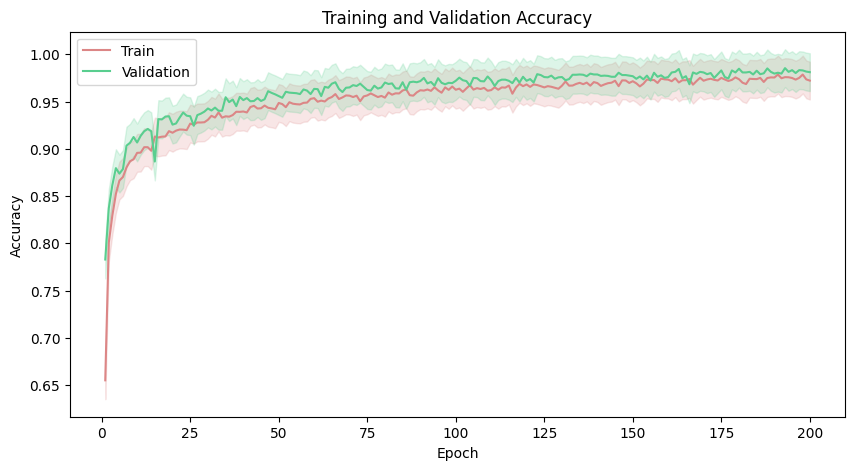

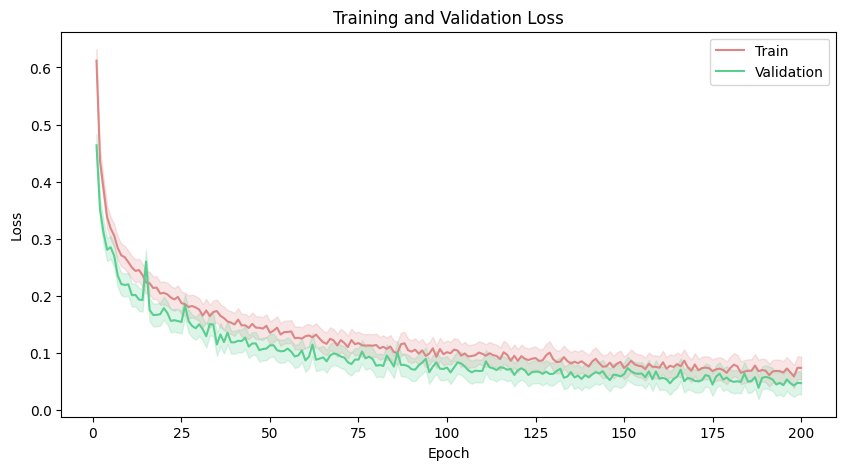

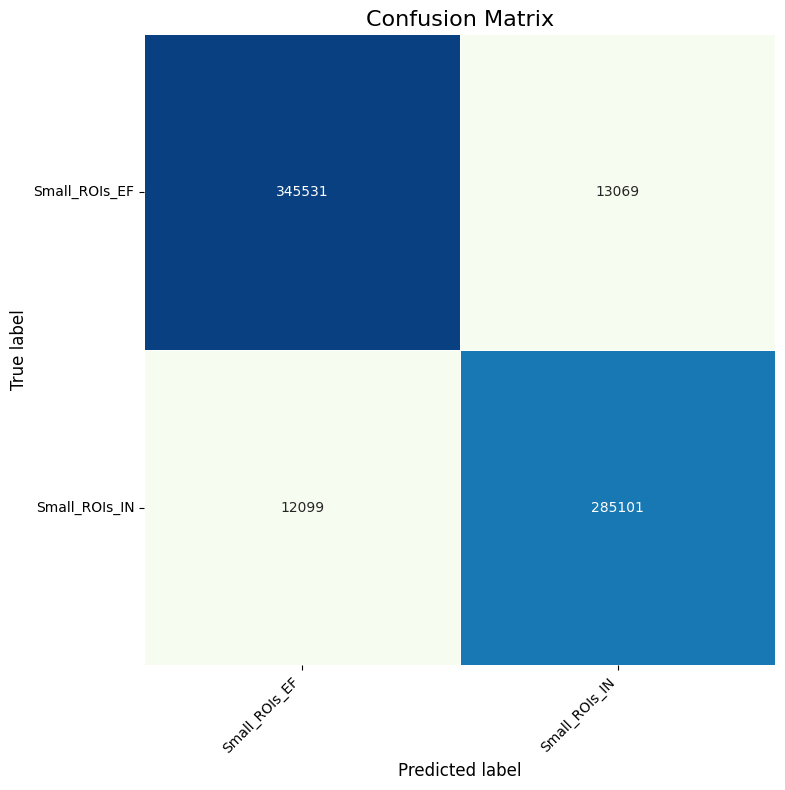

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/kaggle/working/20X_ROIs-dataset_deit_E200_2class_newaug.pt")